In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def readFileAsArr(fileName, source):
    res = []
    file = open('./data/1ms/' + fileName, encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if ind < 100:
            continue
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([source, splitLine[0], splitLine[1], float(splitLine[2])])
    return res

latencies = readFileAsArr('plumber.txt', 'Plumber')
latencies = latencies + readFileAsArr('baseline.txt', 'Baseline')
latencies = latencies + readFileAsArr('dapr.txt', 'Dapr')

In [4]:
df = pd.DataFrame(latencies, columns=['Platform', 'Begin nano', 'End nano', 'Latency (ms)'])

In [5]:
df.groupby(["Platform"]).describe()


Latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      77574.0  1.620901  1.375973  0.950812  1.414855  1.522892   
Dapr          77574.0  1.708796  1.483242  1.093483  1.478202  1.580839   
Plumber       77574.0  1.939413  1.493663  1.226340  1.703793  1.811146   

                               
               75%        max  
Platform                       
Baseline  1.646501  62.830099  
Dapr      1.699582  63.316462  
Plumber   1.937261  63.425133

In [6]:
df.head()

,Platform,Begin nano,End nano,Latency (ms)
0,Plumber,1630065527318417656,1630065527343591782,25.174126
1,Plumber,1630065527319936683,1630065527344352011,24.415328
2,Plumber,1630065527321479674,1630065527345238471,23.758797
3,Plumber,1630065527323137906,1630065527346070416,22.932510
4,Plumber,1630065527324697190,1630065527346693858,21.996668


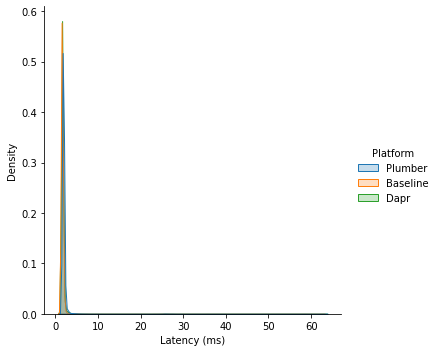

In [7]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True)

In [8]:
df.describe()

,Latency (ms)
count,232722.000000
mean,1.756370
std,1.458127
min,0.950812
25%,1.497555
50%,1.637441
75%,1.797344
max,63.425133


<AxesSubplot:xlabel='Platform', ylabel='Latency (ms)'>

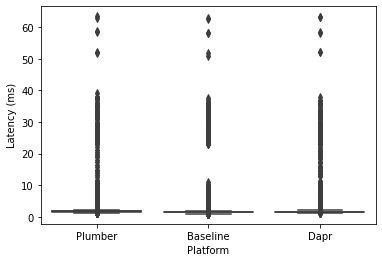

In [9]:
sns.boxplot(data=df, x="Platform", y="Latency (ms)")

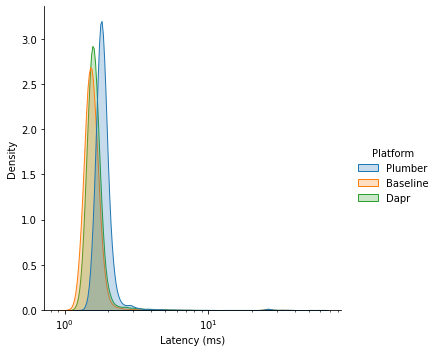

In [10]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True, log_scale=True)

<AxesSubplot:xlabel='Latency (ms)', ylabel='Proportion'>

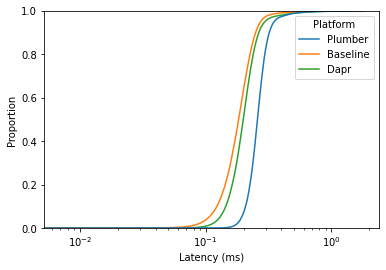

In [11]:
sns.ecdfplot(data=df, x="Latency (ms)", hue="Platform", log_scale=True)

In [12]:
df.shape

(232722, 4)

In [13]:
# Obvious issue with outliers for visualizations: remove them through IQR method
plat_dfs = []
for plat in df["Platform"].unique():
    print(plat)
    df_plat = df[df["Platform"] == plat]
    q1 = df_plat.quantile(0.25)["Latency (ms)"]
    q3 = df_plat.quantile(0.75)["Latency (ms)"]
    iqr = q3 - q1
    print(df_plat.shape)
    df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
    print(df_plat.shape)
    plat_dfs.append(df_plat)

filtered_df = pd.concat(plat_dfs)


Plumber
(77574, 4)
(74178, 4)
Baseline
(77574, 4)
(75405, 4)
Dapr
(77574, 4)
(74302, 4)


<ipython-input-13-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-13-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-13-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)


In [14]:
filtered_df.groupby(["Platform"]).describe()

Latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      75405.0  1.527363  0.162303  1.068256  1.411772  1.516789   
Dapr          74302.0  1.582250  0.153810  1.146296  1.473291  1.572533   
Plumber       74178.0  1.812746  0.164308  1.355570  1.698558  1.801739   

                              
               75%       max  
Platform                      
Baseline  1.634433  1.993892  
Dapr      1.681100  2.031370  
Plumber   1.917339  2.287440

In [15]:
# preprocessing for catplot
df_metrics = pd.DataFrame(columns=["Metric", "Platform", "Latency (ms)"])
for plat in df["Platform"].unique():
    plat_df = df[df["Platform"] == plat]
    df_metrics = df_metrics.append({"Metric": "Median", "Platform": plat, "Latency (ms)": plat_df.quantile(0.5)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "90th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.9)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "99th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.99)["Latency (ms)"]}, ignore_index=True) 

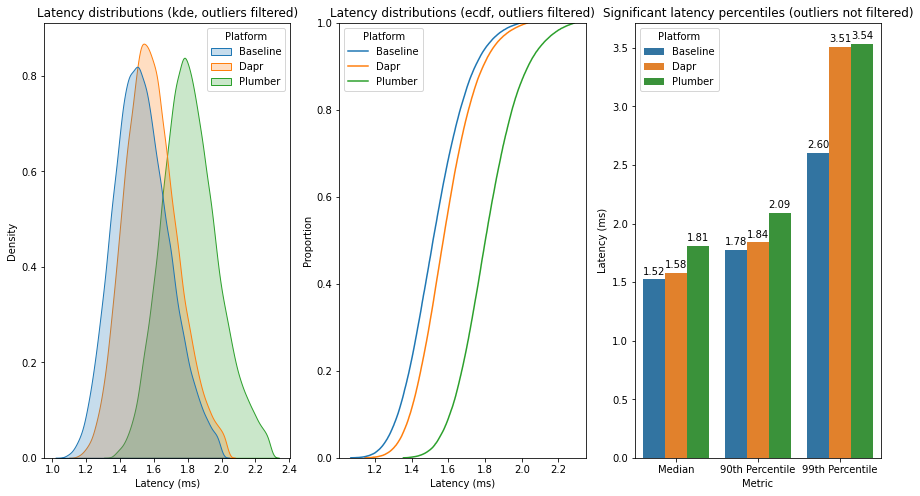

In [16]:

f, axes = plt.subplots(1, 3, figsize=(15,8))
h_order = ["Baseline", "Dapr", "Plumber"]
sns.kdeplot(data=filtered_df, x="Latency (ms)", hue="Platform", fill=True, ax=axes[0], hue_order=h_order)
sns.ecdfplot(data=filtered_df, x="Latency (ms)", hue="Platform", ax=axes[1], hue_order=h_order)
sns.barplot(
    data=df_metrics,
    x="Metric", y="Latency (ms)", hue="Platform",
    hue_order=h_order,
    ax = axes[2]
)

axes[0].title.set_text('Latency distributions (kde, outliers filtered)')
axes[1].title.set_text('Latency distributions (ecdf, outliers filtered)')
axes[2].title.set_text('Significant latency percentiles (outliers not filtered)')


def add_value_labels(ax, spacing=3):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(axes[2])


In [17]:
# calc throughput
df = df.astype({'Begin nano': 'int64'})
delta_s = (df["Begin nano"].max() - df["Begin nano"].min()) / 1_000_000_000
tot_messages = len(df.index) / 3
tot_messages / delta_s

628.3284448616383

In [18]:
df.groupby(["Platform"]).sem()

,Begin nano,Latency (ms)
Platform,,
Baseline,1.278741e+08,0.004940
Dapr,1.278741e+08,0.005325
Plumber,1.278741e+08,0.005363


In [38]:
df.groupby(["Platform"]).describe()

Begin nano                                                          \
              count          mean           std           min           25%   
Platform                                                                      
Baseline    77574.0  1.630066e+18  3.561557e+10  1.630066e+18  1.630066e+18   
Dapr        77574.0  1.630066e+18  3.561557e+10  1.630066e+18  1.630066e+18   
Plumber     77574.0  1.630066e+18  3.561557e+10  1.630066e+18  1.630066e+18   

                                                   Latency (ms)            \
                   50%           75%           max        count      mean   
Platform                                                                    
Baseline  1.630066e+18  1.630066e+18  1.630066e+18      77574.0  1.620901   
Dapr      1.630066e+18  1.630066e+18  1.630066e+18      77574.0  1.708796   
Plumber   1.630066e+18  1.630066e+18  1.630066e+18      77574.0  1.939413   

                                                                       
               std       min       25%       50%       75%        max  
Platform                                                               
Baseline  1.375973  0.950812  1.414855  1.522892  1.646501  62.830099  
Dapr      1.483242  1.093483  1.478202  1.580839  1.699582  63.316462  
Plumber   1.493663  1.226340  1.703793  1.811146  1.937261  63.425133

In [43]:
df.groupby(["Platform"]).quantile(0.9995)

,Begin nano,Latency (ms)
Platform,,
Baseline,1.630066e+18,29.406121
Dapr,1.630066e+18,29.766906
Plumber,1.630066e+18,30.176646


In [33]:
outliers = df[df["Latency (ms)"] > 5]
outliers = outliers[outliers["Latency (ms)"] < 50]

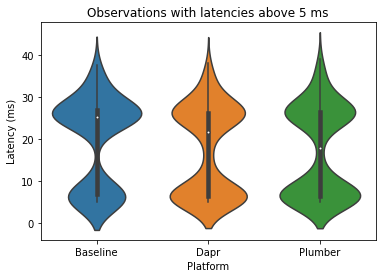

In [45]:

ax = sns.violinplot(x="Platform", y="Latency (ms)", data=outliers, order=["Baseline", "Dapr", "Plumber"])
ax.title.set_text('Observations with latencies above 5 ms')
plt.savefig("vis-latency-outliers-1.png")